https://www.kaggle.com/competitions/test-task-for-ds-churn-prediction-2025-01

In [1]:
# підключення потрібних модулей

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# параметри виведення
pd.set_option("display.max_columns", 500)  # кількість колонок
pd.set_option("display.max_rows", 1000)  # кількість рядків
pd.set_option("display.max_colwidth", 300)  # ширина колонок
pd.set_option("display.precision", 5)  # кількість знаків після коми

# вимикаємо зайві попередження
import warnings

warnings.filterwarnings("ignore")

# друк всіх результатів в одній комірці а не тільки останнього
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# завантаження ML-модулей

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import matthews_corrcoef

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [3]:
# завантаження та первинний огляд трейнового дата-сету
train_data = pd.read_csv(
    "C:\\Users\\user\\Documents\\my-repos\\workshop_testtask\\train.csv",
)
print(train_data.shape)
print(train_data.info())
print(train_data.describe())
print('\nКількість унікальних значень:\n', train_data.nunique())
print('\nКількість пустих значень:\n', train_data.isna().mean())

(24000, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     24000 non-null  int64  
 1   ses_rec        24000 non-null  float64
 2   ses_rec_avg    24000 non-null  float64
 3   ses_rec_sd     24000 non-null  float64
 4   ses_rec_cv     24000 non-null  float64
 5   user_rec       24000 non-null  float64
 6   ses_n          24000 non-null  float64
 7   ses_n_r        24000 non-null  float64
 8   int_n          24000 non-null  float64
 9   int_n_r        24000 non-null  float64
 10  tran_n         24000 non-null  float64
 11  tran_n_r       24000 non-null  float64
 12  rev_sum        24000 non-null  float64
 13  rev_sum_r      24000 non-null  float64
 14  major_spend_r  24000 non-null  float64
 15  int_cat_n_avg  24000 non-null  float64
 16  int_itm_n_avg  24000 non-null  float64
 17  ses_mo_avg     24000 non-null  float64

In [4]:
# завантаження та первинний огляд тестового дата-сету
test_data = pd.read_csv(
    "C:\\Users\\user\\Documents\\my-repos\\workshop_testtask\\test.csv",
)
print(test_data.shape)
print(test_data.info())
print('\nКількість пустих значень:\n', test_data.isna().mean())

(6000, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6000 non-null   int64  
 1   ses_rec        6000 non-null   float64
 2   ses_rec_avg    6000 non-null   float64
 3   ses_rec_sd     6000 non-null   float64
 4   ses_rec_cv     6000 non-null   float64
 5   user_rec       6000 non-null   float64
 6   ses_n          6000 non-null   float64
 7   ses_n_r        6000 non-null   float64
 8   int_n          6000 non-null   float64
 9   int_n_r        6000 non-null   float64
 10  tran_n         6000 non-null   float64
 11  tran_n_r       6000 non-null   float64
 12  rev_sum        6000 non-null   float64
 13  rev_sum_r      6000 non-null   float64
 14  major_spend_r  6000 non-null   float64
 15  int_cat_n_avg  6000 non-null   float64
 16  int_itm_n_avg  6000 non-null   float64
 17  ses_mo_avg     6000 non-null   float64
 1

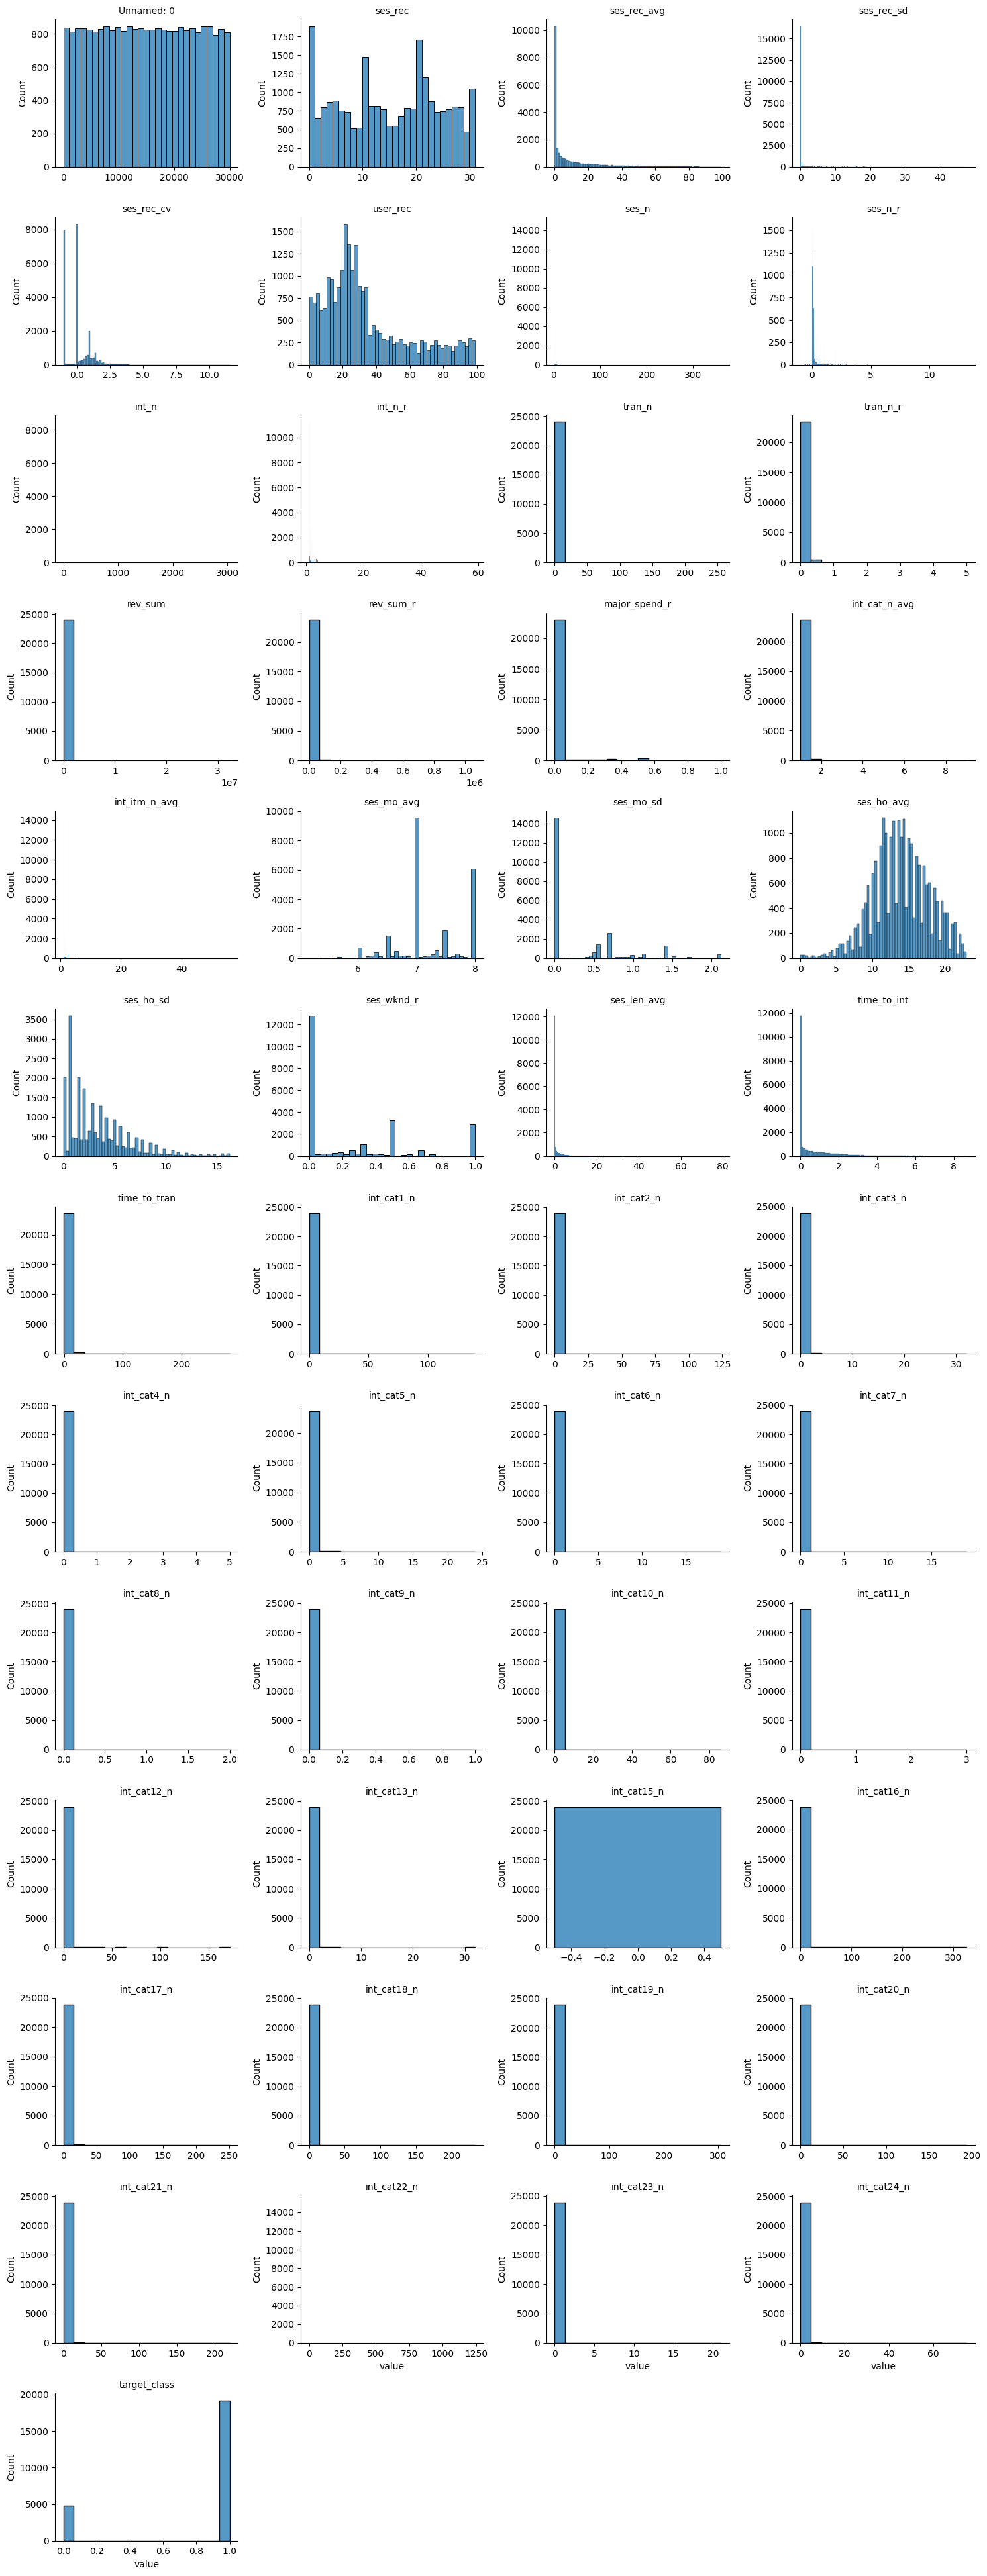

In [5]:
# оглядаємо розподіл

melted = train_data.melt()
g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

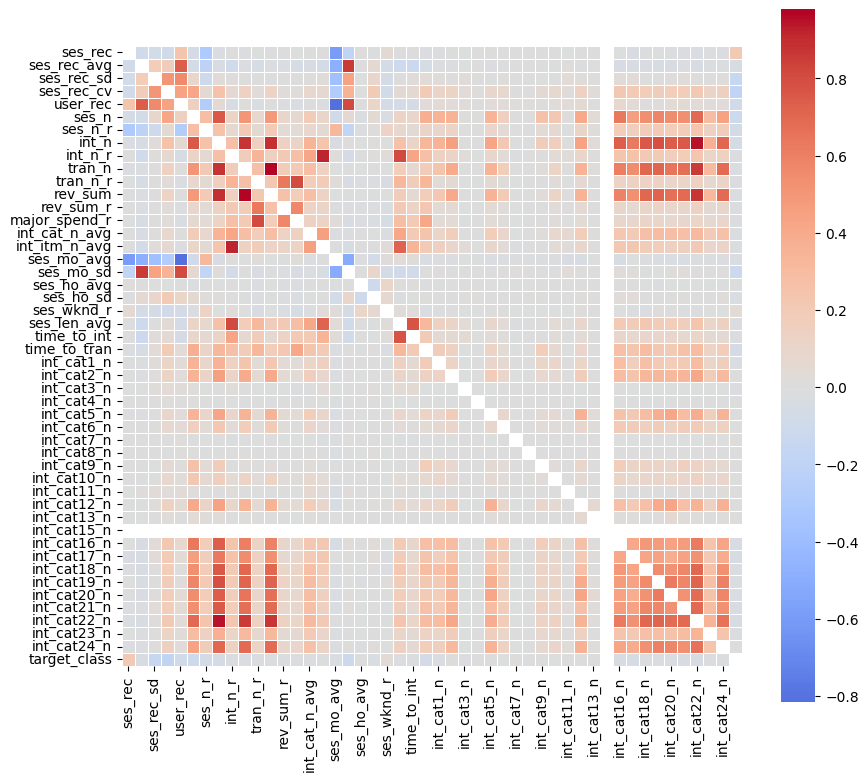

In [6]:
# оглядаємо матрицю кореляції

subset = train_data.drop(columns=['Unnamed: 0',])

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(10, 9))

sns.heatmap(corr_mtx,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

plt.show();

### Висновки:
1. Дані тільки числові, без категоріальних.
2. Пустих значень немає ні в трейновому, ні в тестовому датасеті.
3. Нормальній розподіл тільки у двох ознак - треба використати PowerTransformer для нормалізації інших ознак
4. Ознака має тільки одне унікальне значення, то ж її можна виключити з датасету, т.я. вона не несе користної інформації
5. Можна додати декілька синтетичних ознак - кількість категорій, в яких мала місце активність користувача, а також загальна кількість активностей по каегоріям.

In [5]:
# очистка датасета та формування нових ознак

train_data['cat_act_num'] = train_data.loc[:, 'int_cat1_n':'int_cat24_n'].gt(0).astype('int').sum(axis='columns')
train_data['cat_act_sum'] = train_data.loc[:, 'int_cat1_n':'int_cat24_n'].sum(axis='columns')

drop_columns = ['Unnamed: 0', 'int_cat15_n'] # видаляємо індекс клієнта (унікальний ідентифікатор) та колонку int_cat15_n, яка містить єдине унікальне значення
train_data.drop(columns=drop_columns, inplace=True)
train_data.head(5)

,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,tran_n,tran_n_r,rev_sum,rev_sum_r,major_spend_r,int_cat_n_avg,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,time_to_tran,int_cat1_n,int_cat2_n,int_cat3_n,int_cat4_n,int_cat5_n,int_cat6_n,int_cat7_n,int_cat8_n,int_cat9_n,int_cat10_n,int_cat11_n,int_cat12_n,int_cat13_n,int_cat16_n,int_cat17_n,int_cat18_n,int_cat19_n,int_cat20_n,int_cat21_n,int_cat22_n,int_cat23_n,int_cat24_n,target_class,cat_act_num,cat_act_sum
0,13.0,2.50000,2.50000,1.00000,19.00000,3.00000,0.15789,4.0,1.33333,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.33333,0.57735,15.00000,5.29150,0.00000,1.99444,1.49583,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,4
1,26.0,2.00000,0.00000,0.00000,32.00000,3.00000,0.09375,3.0,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.00000,0.00000,12.33333,2.51661,0.33333,0.00000,0.00000,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3,3
2,22.0,0.00000,0.00000,-1.00000,22.00000,2.00000,0.09091,3.0,1.50000,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.00000,0.00000,13.50000,0.70711,1.00000,0.24167,0.16111,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,1,3
3,0.0,0.08234,0.08234,-0.67066,0.32934,2.16467,-0.58832,5.0,2.36277,0.0,0.0,0.0,0.0,0.0,1.0,1.94511,8.00000,0.00000,10.63723,4.47745,0.05489,0.99006,0.40609,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,5
4,24.0,0.00000,0.00000,-1.00000,24.00000,2.00000,0.08333,4.0,2.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.50000,7.00000,0.00000,14.50000,0.70711,0.00000,5.18333,2.59167,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,1,4


In [6]:
# розділення ознак та цільової змінної
X = train_data.copy()
y = X.pop("target_class")

In [7]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, 
                         discrete_features=True, 
                         random_state=42)

mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)

mi_scores

ses_ho_avg       0.37073
ses_ho_sd        0.36877
ses_n_r          0.33381
user_rec         0.29959
ses_rec          0.28961
time_to_int      0.28515
ses_rec_avg      0.28200
ses_len_avg      0.28134
int_n_r          0.22231
int_n            0.21893
ses_rec_cv       0.20868
ses_rec_sd       0.19511
ses_wknd_r       0.19288
int_itm_n_avg    0.18781
ses_mo_avg       0.12582
ses_n            0.11447
ses_mo_sd        0.10386
cat_act_sum      0.09095
int_cat_n_avg    0.03775
time_to_tran     0.02646
rev_sum_r        0.02635
rev_sum          0.02567
cat_act_num      0.01817
tran_n_r         0.01794
major_spend_r    0.01545
tran_n           0.01066
int_cat22_n      0.00791
int_cat16_n      0.00516
int_cat17_n      0.00453
int_cat19_n      0.00439
int_cat21_n      0.00282
int_cat20_n      0.00213
int_cat12_n      0.00202
int_cat18_n      0.00190
int_cat2_n       0.00184
int_cat1_n       0.00167
int_cat23_n      0.00111
int_cat3_n       0.00070
int_cat5_n       0.00068
int_cat24_n      0.00066


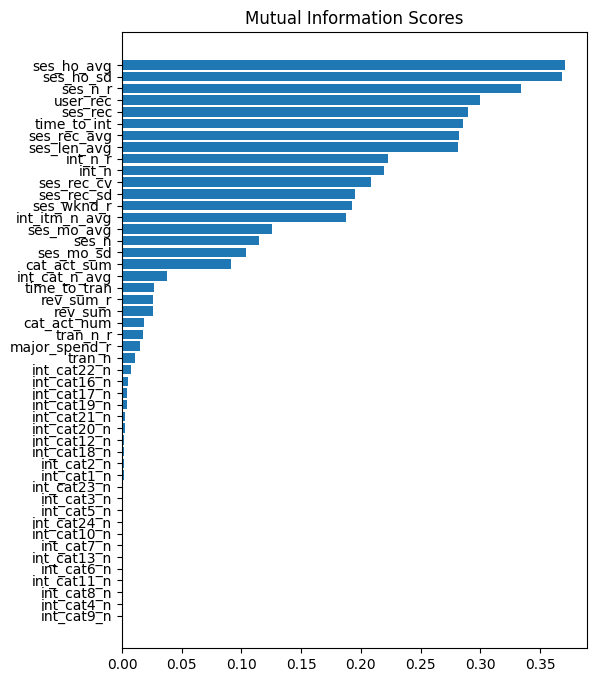

In [8]:
plt.figure(figsize=(6, 8))
mi_scores.sort_values(ascending=True, inplace=True)
plt.barh(np.arange(len(mi_scores)), mi_scores)
plt.yticks(np.arange(len(mi_scores)), mi_scores.index)
plt.title('Mutual Information Scores')
plt.show();

In [8]:
# зменшення кількості ознак

# оптимальні параметри (знайдені методом підбору)
# cardinal_trh = 10 # нічого не видаляємо
mi_important_feat_value = 0.09

# видаляємо малокардинальні ознаки
# drop_not_cardinal_columns_list = list(
#     X.nunique()[X.nunique().lt(cardinal_trh) == True].index
# )
# X.drop(columns=drop_not_cardinal_columns_list, inplace=True)

# видаляємо ознаки, прив'язані до дати формування датасету
# not_sense_cols_list = ["ses_rec", "user_rec", "ses_n_r"]
# X.drop(columns=not_sense_cols_list, inplace=True)

# видаляємо ознаки, які мають mi_scores менше 0.09
mi_important_feat_list = list(mi_scores[mi_scores < mi_important_feat_value].index)
# mi_important_feat_list
X.drop(columns=mi_important_feat_list, inplace=True)

X.head(5)
y.head(5)

,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,cat_act_sum
0,13.0,2.50000,2.50000,1.00000,19.00000,3.00000,0.15789,4.0,1.33333,1.00000,7.33333,0.57735,15.00000,5.29150,0.00000,1.99444,1.49583,4
1,26.0,2.00000,0.00000,0.00000,32.00000,3.00000,0.09375,3.0,1.00000,1.00000,7.00000,0.00000,12.33333,2.51661,0.33333,0.00000,0.00000,3
2,22.0,0.00000,0.00000,-1.00000,22.00000,2.00000,0.09091,3.0,1.50000,1.00000,7.00000,0.00000,13.50000,0.70711,1.00000,0.24167,0.16111,3
3,0.0,0.08234,0.08234,-0.67066,0.32934,2.16467,-0.58832,5.0,2.36277,1.94511,8.00000,0.00000,10.63723,4.47745,0.05489,0.99006,0.40609,5
4,24.0,0.00000,0.00000,-1.00000,24.00000,2.00000,0.08333,4.0,2.00000,1.50000,7.00000,0.00000,14.50000,0.70711,0.00000,5.18333,2.59167,4


0    1
1    1
2    1
3    0
4    1
Name: target_class, dtype: int64

In [9]:
# пайп-лайн

num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
                                missing_values=pd.NA, 
                                  strategy="constant", fill_value=0)), # для універсальності - зараз пустих значень немає, але треба коректно обробляти такі майбутні випадки 
        ("powertransformer", PowerTransformer()),  # метод також нормує дані, тому StandardScaler не потрібен
        # ('scaler', StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("num", num_transformer, make_column_selector(dtype_include=np.number)),],
    n_jobs=2,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

model_pipeline = Pipeline(
    steps=[
        ("pre_processor", preprocessor),
        ("SMOTE", SMOTE(random_state=42, k_neighbors=18)),  # 16
        # ('pca', PCA(random_state=42, n_components=20)), # тільки погіршував результат
        (
            "clf_estimator",
            lgb.LGBMClassifier(
                # subsample=0.99, #0.99
                # n_estimators=500, # 500
                # learning_rate=0.4, # 0.4
                # max_depth=10,  # 3
                # max_features="sqrt",
                random_state=42,
            ),
        ),
    ]
)

In [ ]:
# пошук найкращих гіперпараметрів

# готуємо збалансовані фолди для крос-валідації
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


parameters = {
    # 'clf_estimator__learning_rate': (0.1, 0.3, 0.4,),
    # 'clf_estimator__subsample': (0.75, 0.80, 0.85, 0.90, 0.95, ),
    # 'clf_estimator__max_features': ('sqrt', 'log2'),
    # 'clf_estimator__max_depth': (3, 4, 5, 6, 8, 10, 12, 14), # 10
    # 'clf_estimator__n_estimators': (100, 400, 500, 600),
    # 'SMOTE__k_neighbors': (14, 16, 18, 20, 22) # 18
    }

search = (GridSearchCV(
    estimator=model_pipeline,
    param_grid=parameters,
    scoring='matthews_corrcoef',
    cv=kf,
    refit=False)
    .fit(X, y))

parameters_best = search.best_params_

for param in parameters_best.keys():
    print(f"{param}: {parameters_best[param]}")

In [119]:
# перевіряємо параметри на крос-валідації

cv_results = cross_val_score(
    estimator=model_pipeline,
    X=X,
    y=y,
    scoring="matthews_corrcoef",
    cv=kf,
    verbose=0,
)

# оглядаємо результати по фолдах
print(cv_results)

# розраховуємо середнє значення
mcc_acc = np.abs(cv_results).mean()

print(f"Pipe's MCC accuracy on CV: {mcc_acc: 0.2%}")


[0.88550347 0.88616065 0.88075737 0.88220611 0.9092348 ]
Pipe's MCC accuracy on CV:  88.88%


In [120]:
# тренування моделі на всьому тренувальному дата-сеті
model = model_pipeline.fit(X, y)

y_valid = model.predict(X)
print(f"Train MCC: {matthews_corrcoef(y, y_valid): 0.2%}")

Train MCC:  94.39%


In [121]:
test_data['cat_act_num'] = test_data.loc[:, 'int_cat1_n':'int_cat24_n'].gt(0).astype('int').sum(axis='columns')
test_data['cat_act_sum'] = test_data.loc[:, 'int_cat1_n':'int_cat24_n'].sum(axis='columns')

# drop_columns = ['Unnamed: 0', 'int_cat15_n']
X_pred = test_data.drop(columns=drop_columns,)
# X_pred = X_pred.drop(columns=drop_not_cardinal_columns_list)
X_pred.drop(columns=mi_important_feat_list, inplace=True)

In [122]:
y_pred = model.predict(X_pred)

# зберіганеня предікту в файл для сабмішену в кагл
output = pd.concat([test_data['Unnamed: 0'], pd.Series(y_pred)], axis=1)
output.columns = ['ID', 'target']

output.to_csv(
    "C:\\Users\\user\\Documents\\my-repos\\workshop_testtask\\output_GB_grids.csv",
    index=False,
)

In [123]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      6000 non-null   int64
 1   target  6000 non-null   int64
dtypes: int64(2)
memory usage: 93.9 KB
